## 1.1 data manipulatie

In [1]:
#importeren van packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import holidays
from sklearn.model_selection import train_test_split

In [2]:
#data lezen
df_postnl = pd.read_csv('/datc/parcel/notebooks/data/postnl/20201014_300_klanten.csv', parse_dates=[0])

#selecteren van "klant_153"
custfilter = df_postnl['cust_id'] == 'klant_153'
df_postnl = df_postnl.where(custfilter).dropna()

df_postnl

,procesdag,cust_id,aantal_pakketten,aantal_pakketten_volgende_dag,validation_column
47,2015-01-02,klant_153,5019.0,0.0,train
307,2015-01-03,klant_153,0.0,2713.0,train
567,2015-01-04,klant_153,2713.0,7699.0,train
827,2015-01-05,klant_153,7699.0,7341.0,train
1087,2015-01-06,klant_153,7341.0,4414.0,train
...,...,...,...,...,...
504447,2020-04-25,klant_153,0.0,1311.0,test
504707,2020-04-26,klant_153,1311.0,2.0,test
504967,2020-04-27,klant_153,2.0,8256.0,test
505227,2020-04-28,klant_153,8256.0,4951.0,test


## 1.2 features implementeren

In [3]:
#implementeren van weekdag en feestdagen
df_postnl.insert(loc=1, column='weekdag', value=df_postnl['procesdag'].dt.dayofweek)
df_postnl = pd.get_dummies(df_postnl, columns=['weekdag'])
df_postnl['aantal_pakketten_vorige_week'] = df_postnl['aantal_pakketten'].shift(7)
df_postnl['aantal_pakketten_vorige_week'].fillna(0, inplace=True)
holidays = holidays.Netherlands()
df_postnl['is_feestdag'] = df_postnl['procesdag'].isin(holidays['2015-01-02':'2019-12-31'])

In [4]:
df_postnl

,procesdag,cust_id,aantal_pakketten,aantal_pakketten_volgende_dag,validation_column,weekdag_0,weekdag_1,weekdag_2,weekdag_3,weekdag_4,weekdag_5,weekdag_6,aantal_pakketten_vorige_week,is_feestdag
47,2015-01-02,klant_153,5019.0,0.0,train,0,0,0,0,1,0,0,0.0,False
307,2015-01-03,klant_153,0.0,2713.0,train,0,0,0,0,0,1,0,0.0,False
567,2015-01-04,klant_153,2713.0,7699.0,train,0,0,0,0,0,0,1,0.0,False
827,2015-01-05,klant_153,7699.0,7341.0,train,1,0,0,0,0,0,0,0.0,False
1087,2015-01-06,klant_153,7341.0,4414.0,train,0,1,0,0,0,0,0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504447,2020-04-25,klant_153,0.0,1311.0,test,0,0,0,0,0,1,0,0.0,False
504707,2020-04-26,klant_153,1311.0,2.0,test,0,0,0,0,0,0,1,1778.0,False
504967,2020-04-27,klant_153,2.0,8256.0,test,1,0,0,0,0,0,0,3414.0,False
505227,2020-04-28,klant_153,8256.0,4951.0,test,0,1,0,0,0,0,0,6732.0,False


## 1.3 trainen

In [5]:
#split data
start = df_postnl['procesdag'] >= datetime(year=2015, month=1, day=2)
eind = df_postnl['procesdag'] <= datetime(year=2019, month=11, day=30) #december is te moeilijk om te voorspellen

df_postnl = df_postnl.where(start & eind).dropna()

#split train en test
train_filter = df_postnl['procesdag'] <= datetime(year=2019, month=6, day=30)
val_filter = train_filter[-30:]
test_filter = df_postnl['procesdag'] >= datetime(year=2019, month=7, day=1) #hier kwam de beste r2 score uit

train = df_postnl.where(train_filter).dropna()
val = df_postnl.where(val_filter).dropna()
test = df_postnl.where(test_filter).dropna()

#x train en x test
x_train = train[train.columns[5:]]
x_val = val[val.columns[5:]]
x_test = test[test.columns[5:]]

#y train en y test
y_train = train.loc[:,'aantal_pakketten']
y_val = val.loc[:, 'aantal_pakketten']
y_test = test.loc[:,'aantal_pakketten']

In [6]:
#model fitten
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

## 1.4 testen

In [7]:
#voorspelling
voorspelling = lr.predict(x_test)

## 1.5 plotten

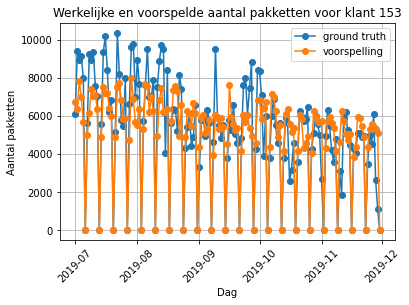

In [11]:
#plot echte waarde tegen voorspelling
fig, ax = plt.subplots()
ax.plot(test['procesdag'], y_test, label='ground truth', marker='o')
ax.plot(test['procesdag'], voorspelling, label='voorspelling', marker='o')
ax.set(
    xlabel='Dag',
    ylabel='Aantal pakketten',
    title='Werkelijke en voorspelde aantal pakketten voor klant 153')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

## 1.6 evalueren

In [9]:
#evalueren
rmse = (np.sqrt(mean_squared_error(y_test, voorspelling)))
r2 = r2_score(y_test, voorspelling)

print('Root Mean Squared Error:', rmse)
print('R2 score:', r2)

Root Mean Squared Error: 1441.739379507216
R2 score: 0.730024672080684


## 1.7 conclusie

In [ ]:
#Het model heeft een r2 score van 0.73. Dit is een redelijk model.